#  Определение перспективного тарифа для телеком компании 

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Краткое описание

* Шаг 1. Вывод таблиц, предобработка данных, приведение таблиц к нужным типам данных, объединение всех таблиц в одну.
* Шаг 2. Анализ показателей, сравнивание парамеров тарифов для определения более прибыльного для компании Мегалайн.
* Шаг 3. Проверка гипотез 
* Шаг 4. Общий вывод.

### Шаг 1. Выгрузка файлов и их проверка

In [1]:
# загрузка датасета со звонками, вывод информации о нём, первых десяти строк 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st


calls = pd.read_csv('/datasets/calls.csv')
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


6.0
7.74
6.755887210214849
8.39779402922807


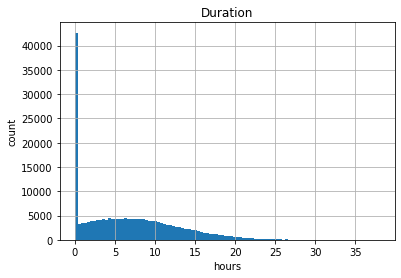

In [2]:
#проверка влияния нулевых звонков на медиану, среднее и на гистограмме
print(calls['duration'].median())
print(calls[calls['duration']!=0]['duration'].median())

print(calls['duration'].mean())
print(calls[calls['duration']!=0]['duration'].mean())
calls['duration'].hist(bins=100)
plt.xlabel('hours')
plt.ylabel('count')
plt.title('Duration')
plt.show()

In [3]:
#приянто решение заменять нулевые звонки на nan, но сначала округление продолжительности звонка до единицы вверх
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
calls['duration'] = calls['duration'].apply(lambda x: None if x == 0 else x)
calls.head(10)
#calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,NaN,1000
1,1000_1,2018-08-17,NaN,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
5,1000_5,2018-11-02,NaN,1000
6,1000_6,2018-10-18,NaN,1000
7,1000_7,2018-08-22,19.0,1000
8,1000_8,2018-09-15,19.0,1000
9,1000_9,2018-08-15,NaN,1000


In [4]:
#изменение столбца с датой на тип данных datetime
calls['call_date'] = pd.to_datetime(calls['call_date']) 
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     162994 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [5]:
## категоризация по месяцу 
calls['month'] = calls['call_date'].dt.month

In [6]:
#создание сводной таблицы по использованным минутам по месяцам
pivot_calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
pivot_calls = pivot_calls.reset_index()
pivot_calls.columns = ['user_id', 'month', 'sum']
pivot_calls['sum'] = pivot_calls['sum'].astype(int)
pivot_calls

,user_id,month,sum
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3169,1498,10,247
3170,1499,9,70
3171,1499,10,449
3172,1499,11,612


In [7]:
# загрузка датасета с использованным трафиком интернета, вывод информации о нём, первых десяти строк 
internet = pd.read_csv('/datasets/internet.csv')
internet.info()
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [8]:
#изменение столбца с датой на тип данных datetime
internet['session_date'] = pd.to_datetime(internet['session_date']) 
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [9]:
# категоризация по месяцу 
internet['month'] = internet['session_date'].dt.month

In [10]:
#создание сводной таблицы по использованным гигабайтам по месяцам
pivot_internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
pivot_internet = pivot_internet.reset_index()
pivot_internet

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


In [11]:
# приведение мегабайтов в гигабайты и округление вверх
pivot_internet['mb_used'] = pivot_internet['mb_used'] / 1024
pivot_internet['mb_used'] = pivot_internet['mb_used'].apply(np.ceil).astype(int)
pivot_internet.head()

,user_id,month,mb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


In [12]:
# загрузка датасета с сообщениями, вывод информации о нём, первых десяти строк 
messages = pd.read_csv('/datasets/messages.csv')
messages.info()
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [13]:
#изменение столбца с датой на тип данных datetime
messages['message_date'] = pd.to_datetime(messages['message_date']) 
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [14]:
#категоризация сообщений по месяцу  
messages['month'] = messages['message_date'].dt.month

In [15]:
#создание сводной таблицы по использованным гигабайтам по месяцам
pivot_messages = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
pivot_messages = pivot_messages.reset_index()
pivot_messages.columns = ['user_id', 'month', 'count']
pivot_messages

,user_id,month,count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [16]:
# загрузка датасета с тарифами, вывод информации о нём, первых десяти строк 
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()
tariffs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
# загрузка датасета с абонентами, вывод информации о нём, первых десяти строк 
users = pd.read_csv('/datasets/users.csv')
users.info()
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [18]:
#просмотр уникальных значений возраста для выявления ошибок 
users['age'].unique()

array([52, 41, 59, 23, 68, 67, 21, 65, 63, 24, 26, 44, 38, 36, 64, 58, 73,
       71, 61, 72, 42, 56, 32, 62, 20, 51, 28, 66, 31, 37, 47, 40, 69, 48,
       33, 39, 43, 46, 45, 55, 53, 34, 49, 25, 18, 70, 50, 19, 54, 60, 29,
       27, 74, 22, 30, 75, 57, 35])

In [19]:
#изменение столбца с датой на тип данных datetime
users['reg_date'] = pd.to_datetime(users['reg_date']) 
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


После открытия таблиц, проверки данных на первый взгляд не было обнаружено никаких сюрпризов, помимо столбцов с датой все остальные имеют тот тип данных, которым соответствуют данные.

In [20]:
# склеивание сводных таблиц
data = pivot_calls.merge(pivot_messages, on=['user_id','month'], how='left')
data2 = data.merge(pivot_internet, on=['user_id','month'], how='left')
data2.columns = ['user_id', 'month', 'calls', 'messages', 'gb']
data2 = data2.fillna(0)
data2['messages'] = data2['messages'].astype(int)
data2['gb'] = data2['gb'].astype(int)
df = data2.merge(users[['user_id', 'city', 'tariff']], on='user_id', how='left')
df

,user_id,month,calls,messages,gb,city,tariff
0,1000,5,159,22,3,Краснодар,ultra
1,1000,6,172,60,23,Краснодар,ultra
2,1000,7,340,75,14,Краснодар,ultra
3,1000,8,408,81,14,Краснодар,ultra
4,1000,9,466,57,15,Краснодар,ultra
...,...,...,...,...,...,...,...
3169,1498,10,247,42,21,Владикавказ,smart
3170,1499,9,70,11,2,Пермь,smart
3171,1499,10,449,48,18,Пермь,smart
3172,1499,11,612,59,18,Пермь,smart


In [21]:
#подсчёт выплаты в сумме за месяц 
def payment(df):
    if df['tariff'] == 'smart':
        smart = 550
        if df['calls'] > 500:
            smart = smart+(df['calls']-500)*3
        if df['messages'] > 50:
            smart = smart+(df['messages']-50)*3
        if df['gb'] >15:
            smart = smart+(df['gb']-15)*200
        return smart
    else: 
        ultra = 1950
        if df['calls'] > 3000:
            ultra = ultra+(df['calls']-500)
        if df['messages'] > 1000:
            ultra = ultra+(df['messages']-50)
        if df['gb'] >30:
            ultra = ultra+(df['gb']-15)*150
        return ultra
df['payment'] = df.apply(payment, axis=1)
df
            
            

,user_id,month,calls,messages,gb,city,tariff,payment
0,1000,5,159,22,3,Краснодар,ultra,1950
1,1000,6,172,60,23,Краснодар,ultra,1950
2,1000,7,340,75,14,Краснодар,ultra,1950
3,1000,8,408,81,14,Краснодар,ultra,1950
4,1000,9,466,57,15,Краснодар,ultra,1950
...,...,...,...,...,...,...,...,...
3169,1498,10,247,42,21,Владикавказ,smart,1750
3170,1499,9,70,11,2,Пермь,smart,550
3171,1499,10,449,48,18,Пермь,smart,1150
3172,1499,11,612,59,18,Пермь,smart,1513


### Шаг 3. Анализ данных. 

За 2018 год выручка по тарифу Ультра составила  2257500 рублей
За 2018 год выручка по тарифу Смарт составила  2869651 рублей


In [39]:
# проверка суммы переплаты по каждoму тарифу за 2018 год по каждому тарифу
def sum_over_const(df):
    if df['tariff'] == 'smart':
        smart = 550
        if df['payment'] > 550:
            smart = df['payment']-smart
        if df['payment'] == 550:
            smart = 0
        return smart
    else:
        ultra = 1950
        if df['payment'] > 1950:
            ultra = df['payment']-ultra
        if df['payment'] == 1950:
            ultra = 0
        return ultra
df['sum_over_const'] = df.apply(sum_over_const, axis=1)
df
            
        

,user_id,month,calls,messages,gb,city,tariff,payment,sum_over_const
0,1000,5,159,22,3,Регион,ultra,1950,0
1,1000,6,172,60,23,Регион,ultra,1950,0
2,1000,7,340,75,14,Регион,ultra,1950,0
3,1000,8,408,81,14,Регион,ultra,1950,0
4,1000,9,466,57,15,Регион,ultra,1950,0
...,...,...,...,...,...,...,...,...,...
3169,1498,10,247,42,21,Регион,smart,1750,1200
3170,1499,9,70,11,2,Регион,smart,550,0
3171,1499,10,449,48,18,Регион,smart,1150,600
3172,1499,11,612,59,18,Регион,smart,1513,963


In [40]:
ultra = df.query('tariff == "ultra"')
smart = df.query('tariff == "smart"')
print('Переплата по тарифу Ультра за 2018 год пользователями составила ', ultra['sum_over_const'].sum(), 'рублей')
print('Переплата по тарифу Смарт за 2018 год пользователями составила ', smart['sum_over_const'].sum(), 'рублей')

Переплата по тарифу Ультра за 2018 год пользователями составила  403050 рублей
Переплата по тарифу Смарт за 2018 год пользователями составила  1647001 рублей


In [ ]:
# подсчитаем общую выручку по каждому тарифу

print('За 2018 год выручка по тарифу Ультра составила ', ultra['payment'].sum(), 'рублей')
print('За 2018 год выручка по тарифу Смарт составила ', smart['payment'].sum(), 'рублей')

In [22]:
# подсчёт среднего значения и стандартного отклоненияпо каждому тарифу через метод describe()
display(df.query('tariff == "smart"').describe())
df.query('tariff == "ultra"').describe()

,user_id,month,calls,messages,gb,payment
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,1245.904184,8.344130,419.062978,33.396311,16.329735,1290.891138
std,145.837842,2.922009,189.325618,28.259437,5.752599,819.119853
min,1001.000000,1.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,285.000000,10.000000,13.000000,550.000000
50%,1239.000000,9.000000,423.000000,28.000000,17.000000,1030.000000
75%,1376.000000,11.000000,545.500000,51.000000,20.000000,1750.000000
max,1499.000000,12.000000,1435.000000,143.000000,38.000000,6770.000000


,user_id,month,calls,messages,gb,payment
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,1264.766562,8.235542,545.451104,49.033649,19.487907,2373.817035
std,140.413405,2.883937,306.925754,46.890656,9.890432,1098.126656
min,1000.000000,1.000000,0.000000,0.000000,0.000000,1950.000000
25%,1148.000000,6.000000,310.000000,5.000000,12.000000,1950.000000
50%,1281.000000,9.000000,528.000000,39.000000,19.000000,1950.000000
75%,1381.000000,11.000000,756.500000,79.000000,27.000000,1950.000000
max,1495.000000,12.000000,1673.000000,224.000000,49.000000,7050.000000


In [23]:
# подсчёт дисперсии по столбцам 
display(np.var(df['calls']))
display(np.var(df['messages']))
display(np.var(df['gb']))
display(np.var(df['payment']))

56641.03470830063

1268.4769582449399

54.53819490353451

1076736.6883520961

По тарифу Смарт: сравнивая средние значения и медиану, можно увидеть, что они не сильно отличаются друг от друга.
mean	1245.904184	8.344130	419.062978	33.396311	16.329735	1290.891138
median	1239.000000	9.000000	423.000000	28.000000	17.000000	1030.000000

По тарифу Ультра: средние значения и медиана также не сильно отличаются друг от друга, за исключением ежемесячной выплаты.
mean	1264.766562	8.235542	545.451104	49.033649	19.487907	2373.817035
median	1281.000000	9.000000	528.000000	39.000000	19.000000	1950.000000

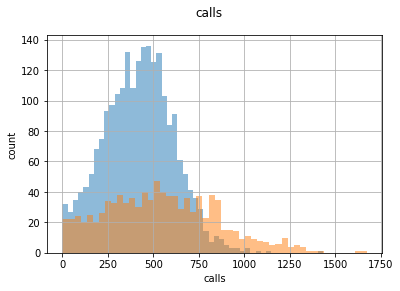

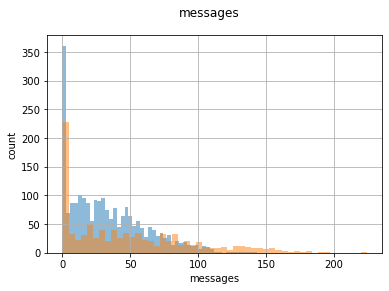

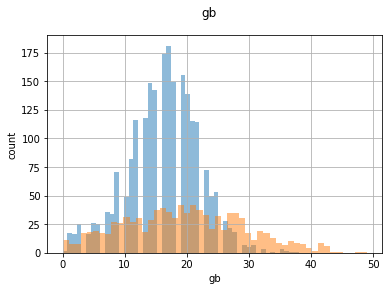

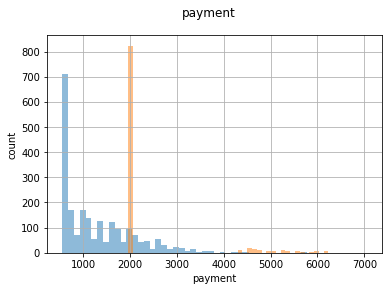

In [24]:
#построение графиков по каждому параметру
columns = ['calls', 'messages', 'gb', 'payment']
for column in columns:
    df.query('tariff == "smart"')[column].hist(bins=50, alpha=0.5)
    df.query('tariff == "ultra"')[column].hist(bins=50, alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('count')
    plt.suptitle(column)
    plt.show()

По гистограммам:
распределения звонков на гисторамме нормальное, также как и на использовании интернет-трафика, а распределения сообщений скошены вправо, что соответствует логике, ведь пользователи ушли от общения по SMS к мессенджерам, чем обусловлено большое количество нулевых значений в сообщениях.
Также распределения по ежеесячным выплатам скошены вправо, что обусловлено тем, что пользователи укладываются в лимиты тарифа и исключительные абоненты выходят за его(тарифа) рамки.

# Шаг 4. Проверка гипотез.

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ различается
Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Параметр equal_var по умолчанию выбирается как True, если его не указывать, что подразумевает, что значения выборок равны. То есть, если по параметру equal_var они будут равны, то подтверждается нулевая гипотеза.

In [25]:
df_smart = df.query('tariff == "smart"')['payment'].reset_index(drop=True)
df_ultra = df.query('tariff == "ultra"')['payment'].reset_index(drop=True)
alpha = 0.05
results = st.ttest_ind(df_smart, df_ultra)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение:  5.437203526505059e-181
Отвергаем нулевую гипотезу


эмпирически полученные данные противоречат нулевой гипотезе, соответственно, делаем вывод: 
средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Нулевая гипотеза: средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов
Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Параметр equal_var по умолчанию выбирается как True, если его не указывать, что подразумевает, что значения выборок равны. То есть, если по параметру equal_var они будут равны, то подтверждается нулевая гипотеза.

In [26]:
# делаем категоризацию городов по Москве и регионам
def city(row):
    if row['city'] == 'Москва':
        return 'Москва'
    else:
        return 'Регион'
df['city'] = df.apply(city, axis=1)
df.head()

,user_id,month,calls,messages,gb,city,tariff,payment
0,1000,5,159,22,3,Регион,ultra,1950
1,1000,6,172,60,23,Регион,ultra,1950
2,1000,7,340,75,14,Регион,ultra,1950
3,1000,8,408,81,14,Регион,ultra,1950
4,1000,9,466,57,15,Регион,ultra,1950


In [27]:
#делаем срезы по Москве и регионам для гипотезы
df_moscow = df.query('city == "Москва"')['payment'].reset_index(drop=True)
df_regions = df.query('city == "Регион"')['payment'].reset_index(drop=True)
#display(df_moscow.describe())
#display(df_moscow)
#df_regions.describe()

In [28]:
alpha = 0.05
results = st.ttest_ind(df_moscow, df_regions)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение:  0.07531986871233416
Не отвергаем нулевую гипотезу


средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других

### Шаг 4. Описание выводов.

Для ответа на вопрос какой тариф выгоднее компании Мегалайн была поднята статистика за 2018 год, проанализировано поведение абонентов и сделаны некоторые выводы:
За 2018 год выручка по тарифу Ультра составила  2.257.500 рублей
За 2018 год выручка по тарифу Смарт составила  2.869.651 рубль

Переплата по тарифу Ультра за 2018 год пользователями составила  403.050 рублей
Переплата по тарифу Смарт за 2018 год пользователями составила  1.647.001 рубль

Что наглядно показывает, что тариф Смарт прибыльнее для компани Мегалайн.

Но клиентов у тарифа Смарт больше клиентов и больше неосознанных людей, которые переплачивают за выход за рамки лимита тарифа. Он приносит компании больший доход, нежели тариф Ультра, но тариф Ультра по конверсии больше, поэтому если больше клиентов на тарифе Ультра, доход увеличится в раза два. Так, например, можно всем людям на тарифе Смарт, вышедшим за пределы его лимита и пересекающим границу абонентской платы Ультра предложить перейти на тариф Ультра.